In [1]:
import torch
import numpy as np
import pandas as pd
from data.Architectures.VGG16_FeaturesOnly import FeaturesOnly

In [2]:
# Create Train-Test Split
# Load the CSV file (Upload your file)
train_csv = "../train_30h.csv" 
df = pd.read_csv(train_csv)
df = df.sample(frac=1).reset_index(drop=True)

# Extract features (from the third column to the second last column)
X_train = df.iloc[:, 2:-1]  # Adjust indexing based on your file structure
y_train = df.iloc[:, -1]  # Last column as labels

# Store feature names BEFORE converting X_train to a tensor
feature_names = X_train.columns.tolist()  # Ensure this is a DataFrame before tensor conversion

test_csv = "../test_30h.csv" 
test_df = pd.read_csv(test_csv)
test_df = test_df.sample(frac=1).reset_index(drop=True)

X_test = test_df.iloc[:, 2:-1]
y_test = test_df.iloc[:, -1]

In [3]:
# Convert to Torch Tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to("cuda")
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to("cuda") 

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to("cuda")
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to("cuda")  # Change dtype if using regression

In [4]:
model = torch.load(r"C:\Users\parde\PycharmProjects\The-model\DeepFakeModel_lr=0.0018225174677877769_bs=16_drop=0.62_layers=4_valloss=0.0768.pth",  map_location=torch.device('cuda'))
model.eval()

C:\Users\parde\AppData\Local\Temp\ipykernel_7856\1049853142.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(r"C:\Users\parde\PycharmProjects\The-model

FeaturesOnly(
  (features_norm): BatchNorm1d(156, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  (dense_layers): Sequential(
    (linear_0): Linear(in_features=156, out_features=104, bias=True)
    (relu_0): ReLU()
    (drop_0): Dropout(p=0.6155282255084615, inplace=False)
    (linear_1): Linear(in_features=104, out_features=52, bias=True)
    (relu_1): ReLU()
    (drop_1): Dropout(p=0.6155282255084615, inplace=False)
    (linear_2): Linear(in_features=52, out_features=1, bias=True)
  )
)

In [5]:
import shap

# Define a wrapper function for SHAP
def model_wrapper(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to("cuda")  # Ensure tensor format
    with torch.no_grad():
        return model(X_tensor).cpu().numpy()  # Get predictions and return as NumPy

# Use SHAP's KernelExplainer (for deep models)
explainer = shap.Explainer(model_wrapper, X_train_tensor.cpu().numpy())

# Compute SHAP values
shap_values = explainer(X_test_tensor.cpu().numpy())

C:\Users\parde\miniforge3\envs\DeepLearning\lib\site-packages\shap\_explanation.py:7: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.0)
  import scipy.cluster
PermutationExplainer explainer: 2425it [02:49, 13.64it/s]                          


In [6]:
shap_values_array = shap_values.values  # (samples, features)

# Compute mean absolute SHAP value per feature
mean_abs_shap = np.mean(np.abs(shap_values_array), axis=0)

# Create DataFrame with feature importance
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,  # Use actual feature names
    "Mean Absolute SHAP Value": mean_abs_shap
}).sort_values(by="Mean Absolute SHAP Value", ascending=False)

print(feature_importance_df.to_string())

                    Feature  Mean Absolute SHAP Value
23             median_16000                  0.077133
51                std_16000                  0.045500
112             mfcc16_mean                  0.037225
39                  std_150                  0.035562
26             variance_255                  0.033841
12               median_255                  0.031585
67                mfcc1_std                  0.028368
49                 std_8000                  0.024018
122             mfcc26_mean                  0.021912
116             mfcc20_mean                  0.021231
7                 F1Formant                  0.019613
55           peak_count_300                  0.019348
42                  std_700                  0.019071
96               mfcc0_mean                  0.018563
27             variance_300                  0.018528
46                 std_3500                  0.018128
47                 std_4000                  0.018046
68                mfcc2_std 

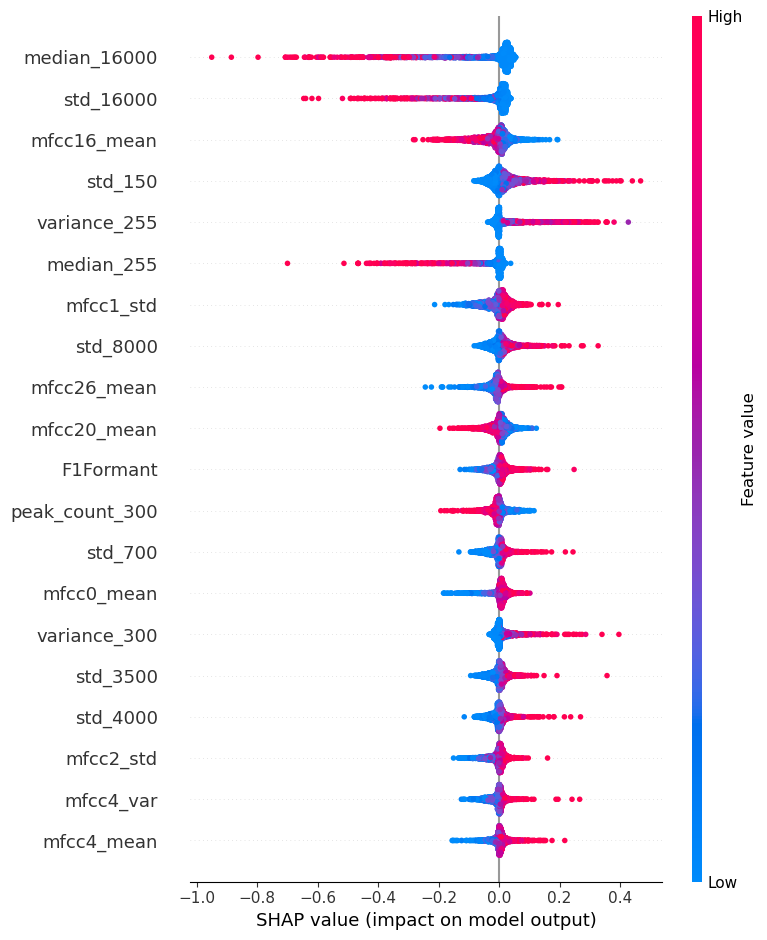

In [7]:
# Summary plot
shap.summary_plot(shap_values, X_test_tensor.cpu().numpy(), feature_names=X_test.columns)


In [8]:
# Use SHAP PermutationExplainer
explainer = shap.Explainer(model_wrapper, X_train_tensor.cpu().numpy())

# Manually compute expected value
expected_value = model_wrapper(X_test_tensor.cpu().numpy()).mean()

# Convert SHAP values into an Explanation object
shap_exp = shap.Explanation(values=shap_values, base_values=expected_value, data=X_test_tensor.cpu().numpy())

# Generate SHAP force plot
shap.force_plot(shap_exp[0])

TypeError: Object of type float32 is not JSON serializable